In [1]:
!pip install numpy --upgrade  # pybulletのインストール時の依存エラー対策(2021/3/18現在)
!pip install pybullet
!git clone https://github.com/bulletphysics/bullet3.git  # 様々なURDFのサンプル
!git clone https://github.com/erwincoumans/pybullet_robots.git  # 様々なロボット

     |████████████████████████████████| 15.3MB 258kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


     |████████████████████████████████| 88.7MB 64kB/s 
Cloning into 'bullet3'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 101959 (delta 0), reused 1 (delta 0), pack-reused 101957
Receiving objects: 100% (101959/101959), 269.38 MiB | 23.52 MiB/s, done.
Resolving deltas: 100% (73899/73899), done.
Checking out files: 100% (7215/7215), done.
Cloning into 'pybullet_robots'...
remote: Enumerating objects: 2782, done.
remote: Total 2782 (delta 0), reused 0 (delta 0), pack-reused 2782
Receiving objects: 100% (2782/2782), 98.93 MiB | 19.72 MiB/s, done.
Resolving deltas: 100% (547/547), done.
Checking out files: 100% (514/514), done.


In [2]:
# Google DriveからSciurus17のデータをコピーしてくる
!cp -r 'drive/MyDrive/Colab Notebooks/松尾研spring_強化学習/data/' '.'

In [3]:
from __future__ import annotations
from base64 import b64encode
import math
import random
import time

from IPython.display import HTML
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import numpy as np
import pandas as pd
import pybullet as p
import pybullet_data

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2088960/45929032 bytes (4.5%)4210688/45929032 bytes (9.2%)6193152/45929032 bytes (13.5%)8413184/45929032 bytes (18.3%)10608640/45929032 bytes (23.1%)12632064/45929032 bytes (27.5%)14614528/45929032 bytes (31.8%)16728064/45929032 bytes (36.4%)18915328/45929032 bytes (41.2%)21053440/45929032 bytes (45.8%)23257088/45929032 bytes (50.6%)25468928/45929032 bytes (55.5%)277

In [4]:
def save_video(frames: list[np.ndarray], path: str, fps: int = 30) -> None:
    """
    動画を保存する関数．

    Args:
        frames (list[np.ndarray]): 動画にする連続した画像のリスト
        path (str): 保存先のパス
        fps (int, optional): 保存する動画のfps. Defaults to 30.
    """
    clip = mpy.ImageSequenceClip(frames, fps=30)
    clip.write_videofile(path, fps)

In [5]:
def play_mp4(path: str) -> HTML:
    """
    Ipython環境下で動画を再生する関数．

    Args:
        path (str): 動画の保存先パス
    Returns:
        HTML: HTMLに動画を埋め込んだオブジェクト
    """
    mp4 = open(path, 'rb').read()
    url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""<video width=400 controls><source src={url} type="video/mp4"></video>""")

In [6]:
def env_show() -> None:
    """今の環境の状態を表示する関数．"""
    # カメラを設定し，画像を取得
    width, height, img_rgb, img_depth, img_seg = p.getCameraImage(360, 240)
    plt.imshow(img_rgb)
    plt.show()

In [7]:
def reset() -> None:
    """環境を初期化する関数．"""
    timestep = 1. / 240

    p.resetSimulation()  # 全オブジェクトを消去
    p.setPhysicsEngineParameter(numSolverIterations=150)
    p.setTimeStep(timestep)

    # 床を配置
    plane_pos = [0, 0, -1]
    plane_id = p.loadURDF('plane.urdf', plane_pos)

    # テーブルを配置
    table_pos = [0.5000000, 0.00000, -.820000]
    table_orn = [0.000000, 0.000000, 0.0, 1.0]
    table_id = p.loadURDF('table/table.urdf', table_pos, table_orn)

    # ブロックを配置(エピソードごとにランダム配置)
    x = 0.5 + 0.2 * random.random()
    y = 0 + 0.25 * random.random()
    ang = math.pi * random.random()
    block_pos = [x, y, -0.1]
    block_orn = p.getQuaternionFromEuler([0, 0, ang])
    block_id = p.loadURDF('block.urdf', block_pos, block_orn)

    p.setGravity(0, 0, -10)  # 重力

    env_show()

In [8]:
# 物理シミュレータに接続して床を配置
physics_client = p.connect(p.DIRECT)  # ローカルなどGUIでみたい場合は p.GUI を指定，p.DIRECTの方がGUIで描画しないため高速
p.setAdditionalSearchPath(pybullet_data.getDataPath())  # URDFのパス追加

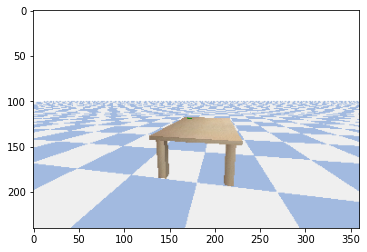

In [9]:
reset()  # 環境リセット用

In [10]:
# 位置と角度を指定してSciurus17を召喚
init_pos = [1, 0, -0.2]
init_orientation = p.getQuaternionFromEuler([0, 0, 3.14])
sciurus_id = p.loadURDF('data/sciurus17/sciurus17.urdf',
                        init_pos, init_orientation)
p.resetBasePositionAndOrientation(sciurus_id, init_pos, init_orientation)  # 初期位置，角度に再配置

In [ ]:
# # 関節の位置を初期化
# other_joint = [0, 0, 0, 0, 0]
# right_arm = [0, math.pi / 2, 0, 0, 0, 0, 0, 0, 0, 0]
# left_arm = [0, -math.pi / 2, 0, 0, 0, 0, 0, 0, 0, 0]
# rp = other_joint + right_arm + left_arm  # reset poses for null spaces
# for j_idx in range(num_joints):
#     p.resetJointState(sciurus_id, j_idx, rp[j_idx])

# width, height, img_rgb, img_depth, img_seg = p.getCameraImage(360, 240)
# plt.imshow(img_rgb)
# plt.show()

In [11]:
# ジョイントの情報を取得
cols = ['joint_index', 'joint_name', 'joint_type', 'q_index', 'u_index', 'flags',
        'joint_damping', 'joint_friction', 'joint_lower_limit', 'joint_upper_limit',
        'joint_max_force', 'joint_max_velocity', 'link_name', 'joint_axis',
        'parent_frame_pos', 'parent_frame_orn', 'parent_index']
df_joint = pd.DataFrame(columns=cols)

num_joints = p.getNumJoints(sciurus_id)
for i in range(num_joints):
    info = p.getJointInfo(sciurus_id, i)
    joint_name = info[1].decode('utf-8')
    df_joint.loc[joint_name] = info
print(df_joint['joint_index'])

waist_yaw_joint        0
chest_camera_joint     1
neck_yaw_joint         2
neck_pitch_joint       3
head_camera_joint      4
r_arm_joint1           5
r_arm_joint2           6
r_arm_joint3           7
r_arm_joint4           8
r_arm_joint5           9
r_arm_armarker        10
r_arm_joint6          11
r_arm_joint7          12
r_hand_joint          13
r_hand_mimic_joint    14
l_arm_joint1          15
l_arm_joint2          16
l_arm_joint3          17
l_arm_joint4          18
l_arm_joint5          19
l_arm_armarker        20
l_arm_joint6          21
l_arm_joint7          22
l_hand_joint          23
l_hand_mimic_joint    24
Name: joint_index, dtype: object


In [12]:
df_joint

,joint_index,joint_name,joint_type,q_index,u_index,flags,joint_damping,joint_friction,joint_lower_limit,joint_upper_limit,joint_max_force,joint_max_velocity,link_name,joint_axis,parent_frame_pos,parent_frame_orn,parent_index
waist_yaw_joint,0,b'waist_yaw_joint',0,7,6,1,0.000001,0.8,-1.919862,1.919862,4.0,5.969211,b'body_link',"(0.0, 0.0, 1.0)","(0.024012, -0.000139, 0.071934)","(0.0, 0.0, 0.0, 1.0)",-1
chest_camera_joint,1,b'chest_camera_joint',4,-1,-1,0,0.000000,0.0,0.000000,-1.000000,0.0,0.000000,b'chest_camera_link',"(0.0, 0.0, 0.0)","(0.057465999999999996, -0.000372, -0.020570000...","(-0.6963642403187991, 0.6963642403223528, -0.1...",0
neck_yaw_joint,2,b'neck_yaw_joint',0,8,7,1,0.000001,0.8,-2.879793,2.879793,4.0,5.969211,b'neck_yaw_link',"(0.0, 0.0, 1.0)","(0.023719999999999998, -0.000372, 0.1012710000...","(0.0, 0.0, 0.0, 1.0)",0
neck_pitch_joint,3,b'neck_pitch_joint',0,9,8,1,0.000001,0.8,-1.570796,1.570796,4.0,5.969211,b'neck_pitch_link',"(0.0, 3.6732051035270885e-06, 0.9999999999932538)","(2.2e-05, -2.9e-05, 0.013139999999999999)","(-0.7071080798594737, 0.0, 0.0, 0.707105482511...",2
head_camera_joint,4,b'head_camera_joint',4,-1,-1,0,0.000000,0.0,0.000000,-1.000000,0.0,0.000000,b'camera_link',"(0.0, 0.0, 0.0)","(0.061806, 0.012312925981160891, -0.0201510452...","(0.7071080798594737, 0.0, 0.0, 0.7071054825112...",3
r_arm_joint1,5,b'r_arm_joint1',0,10,9,1,0.000001,0.8,-1.570796,1.570796,4.0,5.969211,b'r_link1',"(0.0, 3.6732051035270885e-06, 0.9999999999932538)","(0.023719999999999998, -0.096872, 0.0502709999...","(-0.7071080798594737, 0.0, 0.0, 0.707105482511...",0
r_arm_joint2,6,b'r_arm_joint2',0,11,10,1,0.000001,0.8,-1.570796,0.000000,4.0,5.969211,b'r_link2',"(3.6732051035270885e-06, 0.0, -0.9999999999932...","(0.000656, 0.00026406476962380755, 0.017632999...","(0.4999999999966269, -0.4999999999966269, 0.50...",5
r_arm_joint3,7,b'r_arm_joint3',0,12,11,1,0.000001,0.8,-1.570796,1.570796,4.0,5.969211,b'r_link3',"(0.0, 3.6732051035270885e-06, 0.9999999999932538)","(-3.3000679542721514e-05, -0.03104000000000000...","(-0.4999999999966269, 0.4999999999966269, -0.5...",6
r_arm_joint4,8,b'r_arm_joint4',0,13,12,1,0.000001,0.8,0.000000,2.740167,4.0,5.969211,b'r_link4',"(0.0, 0.0, 1.0)","(0.013791, -0.0002447369654540966, 0.071609000...","(0.7071080798594737, 0.0, 0.0, 0.7071054825112...",7
r_arm_joint5,9,b'r_arm_joint5',0,14,13,1,0.000001,0.8,-1.570796,1.570796,4.0,5.969211,b'r_link5',"(0.0, 3.6732051035270885e-06, 0.9999999999932538)","(0.008881, -0.045251, -3.8e-05)","(-0.7071080798594737, 0.0, 0.0, 0.707105482511...",8


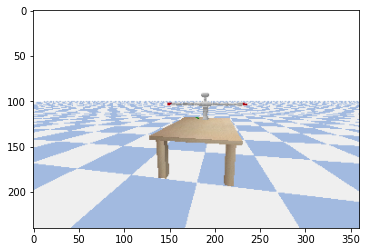

In [29]:
# 質量を0にして倒れないようにする
for l_id in df_joint['joint_index']:
    p.changeDynamics(sciurus_id, l_id, mass=0.0001)

env_show()

In [30]:
# 表示のためのカメラ設定(cameraTargetPositionで位置を微調整)
view_matrix = p.computeViewMatrixFromYawPitchRoll(
    cameraTargetPosition=[2.25, -3, 1.75],  # [2, -3, 2]もいい感じ
	distance=0.5,
	yaw=30,
	pitch=-30,
	roll=0,
	upAxisIndex=2)

# 表示のための投影マトリクス計算(fovで距離を変えられる)
proj_matrix = p.computeProjectionMatrixFOV(
    fov=20, aspect=320/240,  # 10
    nearVal=0.1, farVal=100.0)

In [31]:
# シミュレーションを行う
frames = []
for t in range(300):
    p.stepSimulation()
    if t % 10 == 0:
        # 10フレーム毎の計30フレーム(1s)シミュレーション結果を画像として取得
        width, height, img_rgb, img_depth, img_seg = p.getCameraImage(360, 240,
                                                                      viewMatrix=view_matrix,
                                                                      projectionMatrix=proj_matrix)  # 最新の3.1.0ではタプルで返すので注意
        frames.append(img_rgb)
save_video(frames, 'sciurus_summon.mp4')  # 結果を動画で保存
play_mp4('sciurus_summon.mp4')  # 動画を埋め込み再生

[MoviePy] >>>> Building video sciurus_summon.mp4
[MoviePy] Writing video sciurus_summon.mp4


100%|██████████| 30/30 [00:00<00:00, 429.02it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: sciurus_summon.mp4 



In [40]:
frames = []
t = 0.
free_joints = [0, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14,
               15, 16, 17, 18, 19, 21, 22, 23, 24]
sciurusEndEffectorIndex = 13

for i in range(1000):
    t = t + 0.01
    p.stepSimulation()

    # End Effectorの位置 x-y平面で(-0.6, 0)を中心に半径0.2の円を描くように動く
    pos = [ -0.6 + 0.2 * math.cos(t), 0.2 * math.sin(t), 0.4]
    # pos = [-1, -1, -1]

    # End Effectorの方向
    # 今回は固定
    orn = p.getQuaternionFromEuler([0, -math.pi, 0])
    # IKの計算
    jointPoses = p.calculateInverseKinematics(sciurus_id,
                                              sciurusEndEffectorIndex,
                                              pos,
                                              orn,)
    # IKの計算結果通りに各関節を動かす
    for k, j_idx in enumerate(free_joints):
        p.setJointMotorControl2(bodyIndex=sciurus_id,
                                jointIndex=j_idx,
                                controlMode=p.POSITION_CONTROL,
                                targetPosition=jointPoses[k],
                                targetVelocity=0,
                                force=500,
                                positionGain=0.03,
                                velocityGain=1)

    ls = p.getLinkState(sciurus_id, sciurusEndEffectorIndex)
    if i % 8 == 0:
      width, height, rgbImg, depthImg, segImg = p.getCameraImage(360, 240,
                                                                 viewMatrix=view_matrix,
                                                                 projectionMatrix=proj_matrix)
      frames.append(rgbImg)
save_video(frames, "sample.mp4")
play_mp4("sample.mp4")

[MoviePy] >>>> Building video sample.mp4
[MoviePy] Writing video sample.mp4


100%|██████████| 125/125 [00:00<00:00, 286.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample.mp4 



In [ ]:
p.disconnect()  # 物理シミュレーションから切断

In [14]:
objects = p.loadSDF('bullet3/data/kuka_iiwa/kuka_with_gripper2.sdf')
kuka_id = objects[0]


# ジョイントの情報を取得
cols = ['joint_index', 'joint_name', 'joint_type', 'q_index', 'u_index', 'flags',
        'joint_damping', 'joint_friction', 'joint_lower_limit', 'joint_upper_limit',
        'joint_max_force', 'joint_max_velocity', 'link_name', 'joint_axis',
        'parent_frame_pos', 'parent_frame_orn', 'parent_index']
df_joint = pd.DataFrame(columns=cols)

num_joints = p.getNumJoints(kuka_id)
for i in range(num_joints):
    info = p.getJointInfo(kuka_id, i)
    joint_name = info[1].decode('utf-8')
    df_joint.loc[joint_name] = info
df_joint

,joint_index,joint_name,joint_type,q_index,u_index,flags,joint_damping,joint_friction,joint_lower_limit,joint_upper_limit,joint_max_force,joint_max_velocity,link_name,joint_axis,parent_frame_pos,parent_frame_orn,parent_index
J0,0,b'J0',0,7,6,1,0.5,0.0,-2.96706,2.96706,300.0,10.0,b'lbr_iiwa_link_1',"(0.0, 0.0, 1.0)","(0.1, 0.0, 0.0875)","(0.0, 0.0, 0.0, 1.0)",-1
J1,1,b'J1',0,8,7,1,0.5,0.0,-2.09440,2.09440,300.0,10.0,b'lbr_iiwa_link_2',"(0.0, 0.0, 1.0)","(0.0, 0.03, 0.08249999999999999)","(-9.381873917569987e-07, 0.7071080798588513, 0...",0
J2,2,b'J2',0,9,8,1,0.5,0.0,-2.96706,2.96706,300.0,10.0,b'lbr_iiwa_link_3',"(0.0, 0.0, 1.0)","(-0.0003, 0.14549999999862046, -0.042000751170...","(-9.381873917569987e-07, 0.7071080798588513, 0...",1
J3,3,b'J3',0,10,9,1,0.5,0.0,-2.09440,2.09440,300.0,10.0,b'lbr_iiwa_link_4',"(0.0, 0.0, 1.0)","(0.0, -0.03, 0.08550000000000002)","(-0.7071080798594737, 0.0, 0.0, 0.707105482511...",2
J4,4,b'J4',0,11,10,1,0.5,0.0,-2.96706,2.96706,300.0,10.0,b'lbr_iiwa_link_5',"(0.0, 0.0, 1.0)","(0.0, 0.11749999999875532, -0.03400067770634158)","(9.381873917569989e-07, 0.7071080798588513, 0....",3
J5,5,b'J5',0,12,11,1,0.5,0.0,-2.09440,2.09440,300.0,10.0,b'lbr_iiwa_link_6',"(0.0, 0.0, 1.0)","(-0.0001, -0.021, 0.1394999999999999)","(-0.7071080798594737, 0.0, 1.0080490974868132e...",4
J6,6,b'J6',0,13,12,1,0.5,0.0,-3.05433,3.05433,300.0,10.0,b'lbr_iiwa_link_7',"(0.0, 0.0, 1.0)","(0.0, 0.0803999999994535, -0.00040029752961337...","(-9.381873917569987e-07, 0.7071080798588513, 0...",5
gripper_to_arm,7,b'gripper_to_arm',0,14,13,1,0.0,0.0,0.00000,-1.00000,0.0,0.0,b'base_link',"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.02400000000000004)","(0.0, 0.0, 0.0, 1.0)",6
base_left_finger_joint,8,b'base_left_finger_joint',0,15,14,1,0.0,0.0,-10.40000,10.01000,100.0,0.0,b'left_finger',"(0.0, 1.0, 0.0)","(0.0, 0.024, 0.04500000000000015)","(0.0, 0.024997395914712325, 0.0, 0.99968751627...",7
left_finger_base_joint,9,b'left_finger_base_joint',4,-1,-1,0,0.0,0.0,0.00000,-1.00000,0.0,0.0,b'left_finger_base',"(0.0, 0.0, 0.0)","(-0.0009954177603205688, 0.0, 0.04014991667795...","(0.0, 0.12467473338522773, 0.0, 0.992197667229...",8
